This other notebook use [Octave](https://www.gnu.org/software/octave/), a free clone of MATLAB.

In [1]:
version

ans = 4.2.2


# Iterative computation example (signal filtering)

This short Octave example is meant to show how Julia can be very fast with iterative computations (e.g. `for` loops), thanks to JIT compilation.

Outline:

1. An example of iterative computation: exponential smoothing
2. How to measure the performance of a program using `tic`, `tac`

## A simple iterative computation: Exponential smoothing

[Exponential smoothing](https://en.wikipedia.org/wiki/Exponential_smoothing) (also known as "exponentially weighted moving average", "1st order Autoregressive filter", "1st order IIR filter" in signal processing) is a simple recursive filter which can smooth a times series $\{u_k\}_{k\in\mathbb{N}}$:

$$ y_k = ay_{k-1} + (1-a) u_k, \;\;\;\; k\in\mathbb{N}^+, a\in[0,1[$$

Parameter $a$ tunes the smoothing, between none ($a=0$) and strong smoothing ($a\to1^-$).

This is a simple example of a computation that **cannot be vectorized**. Therefore, iteration in a `for` loop cannot be avoided.

### Example data

a kind of random walk, 1000 pts

In [2]:
randn("seed", 0) % rng(0) in Matlab

In [3]:
u = cumsum(randn(1000,1));
u(1:10)

ans =

  -2.1539
  -3.8406
  -4.1771
  -3.2734
  -3.2200
  -2.8456
  -3.2280
  -3.0542
  -2.5635
  -2.1738



In [4]:
length(u)

ans =  1000


### An Octave implemenation of the smoothing

In [5]:
function y = smooth(u, a)
    y = zeros(length(u),1);
    
    y(1) = (1-a)*u(1);
    for k=2:length(u)
        y(k) = a*y(k-1) + (1-a)*u(k);
    end
end

In [6]:
smooth(u, 0.9)(1:10)

ans =

  -0.21539
  -0.57791
  -0.93783
  -1.17139
  -1.37625
  -1.52318
  -1.69367
  -1.82972
  -1.90310
  -1.93017



### Plot, to check that things work properly

a =  0.95000


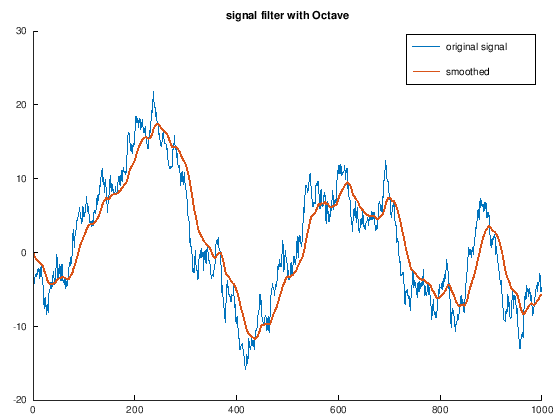

In [12]:
figure();
% Call function here

a = 0.95
hold on;
plot(u);
plot(smooth(u, a), 'linewidth',5);
legend("original signal", "smoothed");
title("signal filter with Octave")
print -dpng signal_filtering_octave.png;

## Performance analysis

With `tic()` and `toc()` like in Matlab.

In [13]:
tic();
smooth(u, 0.9);
toc();

Elapsed time is 0.0166769 seconds.


Since this time is too short to be meaningful, let's use more points (10
M):

In [14]:
randn("seed", 0);
u = cumsum(randn(10^7, 1));

In [15]:
tic();
smooth(u, 0.9);
toc();

Elapsed time is 92.661 seconds.


10 Mpts take **93 s** to compute (compared to **~70 ms** with Julia). Clearly, there is no JIT enabled here. It's even worse than a native Python loop (4.4 s). 

### Octave JIT Compiler

There is a `--jit-compiler` [command line option](https://octave.org/doc/v4.2.2/Command-Line-Options.html) for Octave that should be tried. 

However, on my Debian Stretch system, with Octave 4.2.2 from backports, I get an startup error:

```bash
$ octave --jit-compiler
octave exited with signal 11
```